First see *data/get_data.txt* and *data/processing.ipynb* and *data/classifiers_wo_constraints.ipynb*.

This notebook is another way of showing our method does well. We generate 100 random (well formed) metrics for each of the following datasets:
- Adult (k=2)
- Default (k=2)
- Acoustic (k=3)
- Covtype (k=5)

We have separately generated 80 classifiers for these datasets and produced confusion matrices, which are saved in *data*. We rank these classifiers using the true metric as a scorer. Then, we rank them with:
- the estimated algorithm (from QME)
- the linear oracle (uses just the linear part of the true oracle)
- the accuracy oracle (ones for the linear part of the oracle and zeros for any $B_{ij}$ matrix).

We compare the true ranking to the predicted ranking using the ndcg and kendall-tau methods.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
from scipy.stats import kendalltau
from sklearn.metrics import ndcg_score
from tqdm import tqdm_notebook
import os
from typing import List

import sys
sys.path.append('../')
from common import Sphere, Oracle, create_a_B, normalize
from qme import QME, QMESC

In [3]:
def score_ranking(true_score: np.array, pred_score: np.array):
    '''
    Scores a true ranking against a predicting ranking using NDCG and Kentall Tau metrics.
    '''
    ndcg = ndcg_score([true_score], [pred_score], ignore_ties=True)
    kdtau, _ = kendalltau(true_score, pred_score)
    return ndcg, kdtau


def compute_costs(oracle: Oracle, confusions: np.array) -> np.array:
    '''
    Computes the costs for each confusion matrix
    '''
    costs = []
    for c in confusions:
        costs.append(oracle._score(c))
    return np.array(costs)

In [4]:
np.random.seed(7)

files = [
    "data/confusions_C2_adult.csv",
    "data/confusions_C2_default.csv",
    "data/confusions_C3_acoustic.csv",
    "data/confusions_C5_covtype.csv",
]

dataset_names = [
    "Adult_(k=2)",
    "Default_(k=2)",
    "Acoustic_(k=3)",
    "Covtype_(k=5)"
]


search_tol = 1e-2
trials = 100


colors = ["r", "g", "b", "m"]

linestyle_list = ['solid', 'dashed', 'dotted', "dashdot"]

In [5]:
# run trials across all datasets; runtime: few minutes, no multiprocessing

os.makedirs("trials/qme/ranking/", exist_ok=True)
for i in range(4):
    file = files[i]
    dn = dataset_names[i]
    if os.path.exists(f"trials/qme/ranking/{dn}_est_oracle_scores.npy"):
        print(f"did {dn}")
        continue
    
    df_conf = pd.read_csv(file)
    
    off_diag_colums = []
    for c in df_conf.columns:
        # we extract the row/col from the string name
        # ex: C_01 -> i = 0; j = 1
        i = int(c[2])
        j = int(c[3])
        if i != j:
            off_diag_colums.append(c)
    q = len(off_diag_colums)
    confusions = df_conf[off_diag_colums].values
    
    # list of ndcg scores and kendall-tau scores
    est_oracle_scores = [[], []]
    linear_oracle_scores = [[], []]
    accuracy_oracle_scores = [[], []]
    
    sphere = Sphere(np.zeros(q), 1.0, q)
    wf = True # well-formed metrics
    for _ in tqdm_notebook(range(trials)):
        # we could save these to disk, but nah
        a, B = create_a_B(sphere, q, well_formed=wf)
        true_oracle = Oracle(a, B)

        qm = QME(sphere, true_oracle, search_tol, wf)
        ahat, Bhat = qm.run_qme()
        
        # the estimated oracle
        est_oracle = Oracle(ahat, Bhat)
        
        # linear oracle just uses the true a
        linear_oracle = Oracle(a, np.matrix(np.zeros((q,q))))

        # accuracy oracle will be 1's everywhere for the performance metric a because everything is off-diag
        # (lesser the score, the better). Quadratic costs are all 0.
        acc_oracle = Oracle(np.ones(q), np.matrix(np.zeros((q,q))))
        
        true_costs = compute_costs(true_oracle, confusions)
        est_costs = compute_costs(est_oracle, confusions)
        linear_costs = compute_costs(linear_oracle, confusions)
        acc_costs = compute_costs(acc_oracle, confusions)
        
        # we need to pass score such that higher cost = better; we have been working
        # with cost (lower is better) thus far
        true_score = (1.0 / true_costs)
        est_score = (1.0 / est_costs)
        linear_score = (1.0 / linear_costs)
        acc_score = (1.0 / acc_costs)
        
        # ers = est rank score, lrs = linear rank score, ars = accuracy rank score
        # each is a tuple of (ndcg_score, kendalltau_score)
        ers = score_ranking(true_score, est_score)
        lrs = score_ranking(true_score, linear_score)
        ars = score_ranking(true_score, acc_score)

        est_oracle_scores[0].append(ers[0])
        est_oracle_scores[1].append(ers[1])

        linear_oracle_scores[0].append(lrs[0])
        linear_oracle_scores[1].append(lrs[1])

        accuracy_oracle_scores[0].append(ars[0])
        accuracy_oracle_scores[1].append(ars[1])
                
    est_oracle_scores = np.array(est_oracle_scores)
    linear_oracle_scores = np.array(linear_oracle_scores)
    accuracy_oracle_scores = np.array(accuracy_oracle_scores)
    
    os.makedirs('trials/qme/ranking/', exist_ok=True)
    np.save(f'trials/qme/ranking/{dn}_est_oracle_scores.npy', est_oracle_scores)
    np.save(f'trials/qme/ranking/{dn}_linear_oracle_scores.npy', linear_oracle_scores)
    np.save(f'trials/qme/ranking/{dn}_accuracy_oracle_scores.npy', accuracy_oracle_scores)

did Adult_(k=2)
did Default_(k=2)
did Acoustic_(k=3)
did Covtype_(k=5)


In [6]:
# idx 0: adult
# idx 1: default
# each idx has a tuple (estimated_oracle_score, linear_oracle_score, accuracy_oracle_score)
# each type of score is a tuple (ndcg, kendalltau)
# ex: results[0][0][1] gives all trial results for adult dataset, estimated oracle scores, kendalltau metric
# ex: results[1][1][0] gives all trial results for adult dataset, linear oracle scores, ndcg metric
results = []

for dn in dataset_names:
    eos = np.load(f'trials/qme/ranking/{dn}_est_oracle_scores.npy')
    los = np.load(f'trials/qme/ranking/{dn}_linear_oracle_scores.npy')
    aos = np.load(f'trials/qme/ranking/{dn}_accuracy_oracle_scores.npy')
    
    results.append((eos, los, aos))

In [7]:
def plot_general(m):
    '''
    m: 0 for estimated scores, 1 for linear scores, 2 for accuracy scores
    '''
    plt.figure(figsize=(8,5))
    
    x = [1, 2, 3]

    for i in range(len(dataset_names)):
        eos, los, aos = results[i]
        dn = dataset_names[i]
        
        plt.plot(
            x,
            [ np.median(eos[m,:]), np.median(los[m,:]), np.median(aos[m,:]) ],
            color = colors[i],
            linestyle = linestyle_list[i],
            linewidth = 3,
            label = dn,
        )    
        
    fontP = FontProperties()
    fontP.set_size(15)
    plt.legend(prop = fontP, loc = 'lower left')
    plt.xticks(x, ["elicited", "linear", "accuracy"], weight='bold', fontsize=15)
        
def plot_ndcg():
    m = 0
    plot_general(m)

    plt.ylabel('NDCG',  fontsize = 15, weight = 'bold')

    plt.title('Classifier Ranking Evaluation - NDCG', fontsize = 18, weight = 'bold')
    plt.savefig('./plots/qme/rank_ndcg.png', format = "png", bbox_inches = "tight")
    plt.show()
    
    
def plot_kendalltau():
    m = 1
    plot_general(m)
    
    plt.ylabel('KDTAU',  fontsize = 15, weight = 'bold')

    plt.title('Classifier Ranking Evaluation - KDTAU', fontsize = 18, weight = 'bold')
    plt.savefig('./plots/qme/rank_kdtau.png', format = "png", bbox_inches = "tight")
    plt.show()

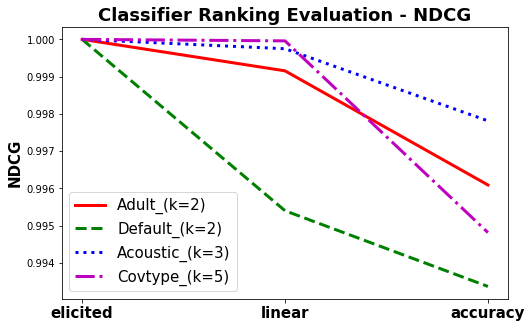

In [8]:
plot_ndcg()

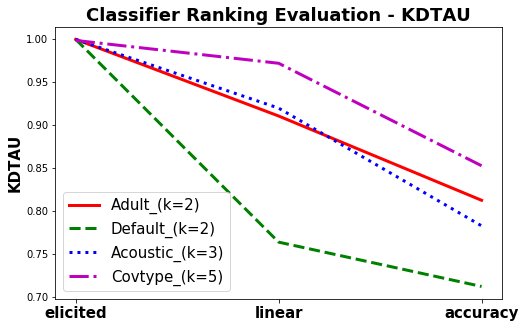

In [9]:
plot_kendalltau()